### import packages
- qulacs for simulation http://docs.qulacs.org/en/latest/
- qulacsvis for circuit visualisation (not necessarily) https://pypi.org/project/qulacsvis/
- quspin for exact diagonalization https://weinbe58.github.io/QuSpin/Installation.html

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [3]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import X, Y, Z, RX, RY, RZ, CNOT, H, to_matrix_gate, merge, add
from qulacs import Observable
#from qulacsvis import circuit_drawer

In [4]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.tools.measurements import obs_vs_time

In [5]:
def add_RZZ_gate(circuit,sub_qubits,param):
    '''
    add exp(i\alpha ZZ/2) to the circuit
    input:
    - circuit: quantum circuit as QuantumCircuit
    - sub_qubits: indices of qubits on which RZZ gate acts
    - param: angle (\alpha)
    '''
    circuit.add_CNOT_gate(sub_qubits[0],sub_qubits[1])
    circuit.add_RZ_gate(sub_qubits[1],param)
    circuit.add_CNOT_gate(sub_qubits[0],sub_qubits[1])

In [6]:
def make_ansatz_HVA(params,num_qubits,num_layers):
    '''
    construct Hamiltonian variational ansatz
    - input
        - num_qubits: number of qubits (N)
        - num_layers: number of layers (L)
        - params: list parameters (number of parameters: (3*num_qubits-2)*num_layers)
    - output: ansatz as QuantumCircuit
    '''
    circuit = QuantumCircuit(num_qubits)
    #initialization to be in correct mag sector
    # for qubit in range(num_qubits):
    #     circuit.add_H_gate(qubit)
    params_index = 0
    for layer in range(num_layers):
        # #RXY even
        # for qubit in range(0,num_qubits-1,2):
        #     add_RXY_gate(circuit,[qubit,qubit+1],params[params_index])
        #     params_index += 1
        # #RXY odd
        # for qubit in range(1,num_qubits-1,2):
        #     add_RXY_gate(circuit,[qubit,qubit+1],params[params_index])
        #     params_index += 1
        
        #RZZ even
        for qubit in range(0,num_qubits-1,2):
            add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RZZ odd
        for qubit in range(1,num_qubits-1,2):
            add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RX
        for qubit in range(num_qubits):
            circuit.add_RX_gate(qubit,params[params_index])
            params_index += 1
    return circuit

## construct quantum circuit for computing matrices $A_{ij}$ and $C_i$
$A_{ij}$ and $C_{i}$ are defined by
$$
A_{ij} = \frac{\partial \langle \psi|}{\partial \theta_{i}} \frac{\partial  |\psi\rangle}{\partial \theta_{j}}
,\quad
C_{i} = \frac{\partial \langle \psi|}{\partial \theta_{i}} H |\psi\rangle\,.
$$

In time dependent variational principle (TDVP), we are instrested in the imaginary (real) part of $A_{ij}$ ($C_{i}$).
$$ M_{ij} := i A_{ij} +\text{h.c.} = 2 \text{Re}[i A_{ij}]
,\quad
V_{i} := C_{i} +\text{h.c.} = 2 \text{Re}[C_{i}]\,.
$$

They can be computed by the circuit given in FIG. 2 in [Li-Benjamin].
- for $M_{ij}$, $a=1/2, \theta=\pi/2$
- for $V_{i}$, $a=1\times(\text{coeff. in Hamiltonian}), \theta = -\pi/2$

On the other hand, in MacLaclan's variational princle, we need
$$ M_{ij} := A_{ij} +\text{h.c.} = 2 \text{Re}[A_{ij}]
,\quad
V_{i} := -i C_{i} +\text{h.c.} = 2 \text{Re}[(-i)C_{i}]\,.
$$

Thus the corresponding coefficients in FIG. 2 in [Li-Benjamin] are given by
- for $M_{ij}$, $a=1/2, \theta=0$
- for $V_{i}$, $a=\red{-1}\times(\text{coeff. in Hamiltonian}), \theta = \red{0}$ (**Changed convention. Dec.12, 2022. Results are same** )

Construct Controlled Unitaries:
- https://docs.qulacs.org/en/latest/guide/2.0_python_advanced.html#Add-control-bit
- https://docs.qulacs.org/en/latest/guide/2.0_python_advanced.html#Gate-product

In [7]:
def add_conditional_RX_gate(circuit,qubit_ancilla, qubit_target, param, params_index,deriv_index_list):
    ''' 
    if params_index is equal to one element in deriv_index_list, then add RZ.CZ to circuit (instead of RZ)
    - input:
        - circuit: quantum circuit
        - qubit_ancilla: index of ancilla qubit
        - qubit_target: index of target qubit (on which RZ acts on)
        - param: rotation angle
        - params_index: index of parameter
        - deriv_index_list: list of index [i,j] wrt which we take derivative (i<j)
    -output: None
    '''
    #derivative wrt RZ gate
    if deriv_index_list[0] == params_index or deriv_index_list[1] == params_index:
        circuit.add_X_gate(qubit_ancilla) #add X gate
        circuit.add_CNOT_gate(qubit_ancilla,qubit_target) #add CX gate 
    circuit.add_RX_gate(qubit_target,param) #add RX gate

In [8]:
def add_conditional_RZZ_gate(circuit,qubit_ancilla, qubits_target, param, params_index,deriv_index_list):
    ''' 
    if params_index is equal to one element in deriv_index_list, then add RZ.CZ to circuit (instead of RZ) two between CNOTs
    - input:
        - circuit: quantum circuit
        - qubit_ancilla: index of ancilla qubit
        - qubits_target: list of indices of target qubits (on which RZ acts on)
        - param: rotation angle
        - params_index: index of parameter
        - deriv_index_list: list of index [i,j] wrt which we take derivative (i<j)
    -output: None
    '''
    #derivative wrt RZ gate
    circuit.add_CNOT_gate(qubits_target[0],qubits_target[1])
    if deriv_index_list[0] == params_index or deriv_index_list[1] == params_index:
        circuit.add_X_gate(qubit_ancilla) #add X gate
        circuit.add_CZ_gate(qubit_ancilla,qubits_target[1]) #add CZ gate 
    circuit.add_RZ_gate(qubits_target[1],param) #add RZ gate
    circuit.add_CNOT_gate(qubits_target[0],qubits_target[1])

**I changed a normalization factor in front of the (XX+YY) [NOV.15, 2022]**

In [9]:
def make_M_circuit_HVA(params,num_qubits,num_layers,deriv_index_list):
    '''
    circuit for M_{ij}
    - input
        - num_qubits: number of qubits (N)
        - num_layers: number of layers (L)
        - params: list parameters (\theta) (number of parameters: 2*num_qubits*num_layers)
        - deriv_index_list (list): indices for parameters which we want to take derivative with respect to. ([i,j] for M_{ij}. (i<j))
    - output: quantum circuit
    '''
    circuit = QuantumCircuit(num_qubits+1) #make quantum circuit with N-registers and 1-ancilla 
    qubit_ancilla = num_qubits #ancilla in last qubit

    #make initial state in physical qubits
    # for qubit in range(num_qubits):
    #     circuit.add_H_gate(qubit)

    circuit.add_H_gate(qubit_ancilla) # make (|0>+|1>)/sqrt(2) in ancilla
    # circuit.add_S_gate(qubit_ancilla) # make (|0>+i|1>)/sqrt(2) as an initial state (eta=1 in Li-Benjamin) in ancilla

    params_index = 0
    for layer in range(num_layers):
        #RZZ even
        for qubit in range(0,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RZZ odd
        for qubit in range(1,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RX 
        for qubit in range(num_qubits):
            add_conditional_RX_gate(circuit,qubit_ancilla, qubit, params[params_index], params_index,deriv_index_list)
            # circuit.add_RZ_gate(qubit,params[params_index])
            params_index += 1

    circuit.add_H_gate(qubit_ancilla) #basis rotation for measurements in {|+>, |->} basis 
    
    return circuit

In [10]:
def make_V_circuit_HVA(params,num_qubits,num_layers,deriv_index):
    '''
    circuit for V_{i}
    - input
        - num_qubits: number of qubits (N)
        - num_layers: number of layers (L)
        - params: list parameters (\theta) (number of parameters: 2*num_qubits*num_layers)
        - deriv_index: index of a parameter with respect to which we want to take derivative. (i for V_{i})
    - output: dictionary of quantum circuit
        - key: terms in Hamiltonian (str)
        - value: quantum circuit corresponding to the key
    '''
    circuit = QuantumCircuit(num_qubits+1) #N-register + ancilla
    qubit_ancilla = num_qubits #ancilla in last qubit

    #make initial state in physical qubits
    # for qubit in range(num_qubits):
    #     circuit.add_H_gate(qubit)
        
    circuit.add_H_gate(qubit_ancilla) # make (|0>+|1>)/sqrt(2) in ancilla qubit #changed, Dec. 12, 2022

    deriv_index_list = [deriv_index,len(params)*10]
    params_index = 0
    for layer in range(num_layers):
        #RZZ even
        for qubit in range(0,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RZZ odd
        for qubit in range(1,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
    
        #RZ 
        for qubit in range(num_qubits):
            add_conditional_RX_gate(circuit,qubit_ancilla, qubit, params[params_index], params_index,deriv_index_list)
            # circuit.add_RZ_gate(qubit,params[params_index])
            params_index += 1

    #make quantum circuits for each term {h_j} in Hamiltonian
    circuit_dict = {}
    #X term in Hamiltonian
    for qubit in range(num_qubits):
        term = f"X {qubit}"
        circuit_x = circuit.copy() #copy circuit
        circuit_x.add_X_gate(qubit_ancilla) #add X gate
        circuit_x.add_CNOT_gate(qubit_ancilla,qubit) #add control-h_j (here h_j = X)
        circuit_x.add_H_gate(qubit_ancilla) #basis rotation for measurements in {|+>, |->} basis
        circuit_dict[term] = circuit_x

    #ZZ term in Hamiltonian
    for qubit in range(num_qubits-1):
        term = f"Z {qubit} Z {qubit+1}"
        circuit_zz = circuit.copy() #copy circuit
        circuit_zz.add_X_gate(qubit_ancilla) #add X gate
        circuit_zz.add_CZ_gate(qubit_ancilla,qubit) #add control-h_j (here h_j = ZZ)
        circuit_zz.add_CZ_gate(qubit_ancilla,qubit+1) #add control-h_j (here h_j = ZZ)
        circuit_zz.add_H_gate(qubit_ancilla) #basis rotation for measurements in {|+>, |->} basis
        circuit_dict[term] = circuit_zz
    return circuit_dict

When we include global phase, we have the following correction terms.
$$
M_{ij} \to M_{ij}-\frac{1}{2}\gamma_{i}\gamma_{j}\,,
$$
$$
V_{i} \to V_{i}+\gamma_{i}{\langle H\rangle}_{\psi}\,,
$$
where $\gamma_{i} = \text{Re}\left[\hat{U}_{i} U\right]$, ${\langle H\rangle}_{\psi}=\langle\psi|H|\psi\rangle$.
The correction vector $\gamma_{i}$ can be evaluated by the same circuit for $V_{i}$ with a replacement $H\to I$.
The initial state in the ancilla qubit is determined by $a=1$ and $\theta=\red{0}$.

**AN ERROR IS CORRECTED, ($\theta=\pi/2\to0$), Nov.30, 2022** 

In [11]:
def make_correction_circuit_HVA(params,num_qubits,num_layers,deriv_index):
    '''
    circuit for gamma_{i}
    - input
        - num_qubits: number of qubits (N)
        - num_layers: number of layers (L)
        - params: list parameters (\theta) (number of parameters: (3*num_qubits-2)*num_layers)
        - deriv_index: index of a parameter with respect to which we want to take derivative. (i for V_{i})

    '''
    circuit = QuantumCircuit(num_qubits+1) #N-register + ancilla
    qubit_ancilla = num_qubits #ancilla in last qubit

    # for qubit in range(num_qubits):
    #     circuit.add_H_gate(qubit)
    circuit.add_H_gate(qubit_ancilla) # make (|0>+|1>)/sqrt(2) in ancilla qubit # fixed Nov. 29
    
    deriv_index_list = [deriv_index,len(params)*10]
    params_index = 0
    for layer in range(num_layers):
        #RZZ even
        for qubit in range(0,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RZZ odd
        for qubit in range(1,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RX
        for qubit in range(num_qubits):
            add_conditional_RX_gate(circuit,qubit_ancilla, qubit, params[params_index], params_index,deriv_index_list)
            # circuit.add_RZ_gate(qubit,params[params_index])
            params_index += 1

    circuit.add_X_gate(qubit_ancilla) #add X gate
    circuit.add_H_gate(qubit_ancilla) #basis rotation for measurements in {|+>, |->} basis
    return circuit

In [12]:
def compute_M_matrix_HVA(params,num_qubits,num_layers):
    '''
    compute M_{ij}
    - input
        - num_qubits: number of qubits (N)
        - num_layers: number of layers (L)
        - params: list parameters (\theta) (number of parameters: 2*num_qubits*num_layers)
    - output: M_{ij} as numpy array
    '''
    num_params = len(params)
    M_mat = np.zeros((num_params,num_params)) # as numpy array
    qubit_ancilla = num_qubits
    for i in range(num_params-1):
        for j in range(i+1,num_params):
            deriv_index_list = [i,j]
            #make quantum state
            state = QuantumState(num_qubits+1)
            state.set_zero_state()

            #make quantum circuit
            circuit = make_M_circuit_HVA(params,num_qubits,num_layers,deriv_index_list)
            #update quantum state
            circuit.update_quantum_state(state)
            #measurement of ancilla qubit
            zero_probability = state.get_zero_probability(qubit_ancilla)
            
            #compute gamma_i
            circuit_correction1 = make_correction_circuit_HVA(params,num_qubits,num_layers,deriv_index_list[0])
            state_correction1 = QuantumState(num_qubits+1)
            state_correction1.set_zero_state()
            circuit_correction1.update_quantum_state(state_correction1)
            zero_probability_correction1 = state_correction1.get_zero_probability(qubit_ancilla)
            gamma1 = (2*zero_probability_correction1 - 1)

            #compute gamma_j
            circuit_correction2 = make_correction_circuit_HVA(params,num_qubits,num_layers,deriv_index_list[1])
            state_correction2 = QuantumState(num_qubits+1)
            state_correction2.set_zero_state()
            circuit_correction2.update_quantum_state(state_correction2)
            zero_probability_correction2 = state_correction2.get_zero_probability(qubit_ancilla)
            gamma2 = (2*zero_probability_correction2 - 1)
            
            M_mat_element = (2*zero_probability - 1)/2 - gamma1*gamma2/2
            M_mat[i,j] = M_mat_element
            
    for i in range(num_params):
        circuit_correction = make_correction_circuit_HVA(params,num_qubits,num_layers,i)
        state_correction = QuantumState(num_qubits+1)
        state_correction.set_zero_state()
        circuit_correction.update_quantum_state(state_correction)
        zero_probability_correction = state_correction.get_zero_probability(qubit_ancilla)
        gamma = (2*zero_probability_correction - 1)
        M_mat[i,i] = 1/2 - (gamma**2)/2 #bug fixed oct. 28, 2022 (add correction term)
        # print(M_mat[i,i])
    for i in range(num_params):
        for j in range(i):
            M_mat[i,j] = M_mat[j,i]
    return M_mat

In [13]:
def make_coeff_dict(num_qubits,j_coupling,h_coupling):
    '''
    make coefficient dictionary from Hamiltonian
    - input:
        - num_qubits: number of qubits (N)
        - j_coupling: coefficient of ZZ terms (J)
        - h_coupling: coefficient of X terms (h)
    - output: coefficient dictionary
        - key: terms in Hamiltonian (str)
        - value: coresponding coefficient
    '''
    # w = 1/2/a #coeff in front of fermion kin. term
    # j_coupling = g*g*a/2 #coeff in front of gauge kin. term

    #make output dictionary 
    coeff_dict = {}

    #X terms
    for i in range(num_qubits):
        term = f"X {i}"
        coeff_dict[term] = -h_coupling
    
    #ZZ terms
    for i in range(num_qubits-1):
        term = f"Z {i} Z {i+1}"
        coeff_dict[term] = -j_coupling

    return coeff_dict

In [14]:
def compute_energy(params,num_qubits,num_layers,j_coupling,h_coupling):

    ansatz = make_ansatz_HVA(params,num_qubits,num_layers)

    state = QuantumState(num_qubits)
    state.set_zero_state()
    
    coeff_dict = make_coeff_dict(num_qubits,j_coupling,h_coupling)
    observable = Observable(num_qubits)

    for term, coeff in coeff_dict.items():
        observable.add_operator(coeff,term)

    ansatz.update_quantum_state(state)
    value = observable.get_expectation_value(state)

    return value

In [15]:
def compute_V_vector_HVA(params,num_qubits,num_layers,j_coupling,h_coupling):
    '''
    compute V_{i}
    - input:
        - num_qubits: number of qubits (N)
        - j_coupling,h_coupling: Hamiltonian parameter (J, h)
    - output: V_{i} as numpy array
    '''
    num_params = len(params)
    V_vec = np.zeros(num_params) # as numpy array
    qubit_ancilla = num_qubits
    for i in range(num_params):
        deriv_index = i
        circuit_dict = make_V_circuit_HVA(params,num_qubits,num_layers,deriv_index)
        coeff_dict = make_coeff_dict(num_qubits,j_coupling,h_coupling)
        V_vec_element = 0.0
        for term, circuit in circuit_dict.items():
            state = QuantumState(num_qubits+1)
            state.set_zero_state()

            circuit_copy = circuit.copy()
            circuit_copy.update_quantum_state(state)
            #measurement of ancilla qubit
            zero_probability = state.get_zero_probability(qubit_ancilla)
            V_vec_element += -(2*zero_probability - 1) * coeff_dict[term] #changed Dec.12, 2022

        #compute gamma_i
        state_correction = QuantumState(num_qubits+1)
        state_correction.set_zero_state()
        circuit_correction = make_correction_circuit_HVA(params,num_qubits,num_layers,deriv_index)
        circuit_correction.update_quantum_state(state_correction)

        zero_probability_correction = state_correction.get_zero_probability(qubit_ancilla)
        gamma = 2*zero_probability_correction - 1

        #compute <H>
        energy = compute_energy(params,num_qubits,num_layers,j_coupling,h_coupling)

        V_vec[i] = V_vec_element + gamma*energy
    return V_vec

In [16]:
def compute_state(params,num_qubits,num_layers):
    """ 
    compute state for a given set of params
    input:
        - params: parameters
        - num_qubits: number of qubits
        - num_layers: number of layers
    output: statevector
    """
    #make ansatz
    ansatz = make_ansatz_HVA(params,num_qubits,num_layers)

    #make initial satate |0>
    state = QuantumState(num_qubits)
    state.set_zero_state()

    #compute statevector
    ansatz.update_quantum_state(state)
    state_vector = state.get_vector()
    return state_vector

In [17]:
def make_mapping_reverse(num_qubits):
    ''' 
    make a list of inversed binary
    ex: for 3q case,
    [000,001,010,011,...,111] -> [000,100,010,110,...,111]
    '''
    num_elements = 2**num_qubits #number of vector elements
    index_list = range(num_elements) #list of index
    index_rev_list = [] 
    for index in index_list:
        index_bin = bin(index)[2:] #translate index into binary
        index_bin = index_bin.zfill(num_qubits) #zerofill to align the length of binary
        index_bin_rev = ''.join(list(reversed(index_bin))) #reversed binary
        index_rev =  int(index_bin_rev,2) #translate reversed binary into decimal
        index_rev_list.append(index_rev) 
    return index_rev_list
def map_state_reverse(state):
    ''' 
    reorder states in different convention
    ex: for 3q case,
    [C_{000},C_{001},C_{010},C_{011},...,C_{111}] -> [C_{000},C_{100},C_{010},C_{110},...,C_{111}]
    '''
    num_elements = len(state)
    num_qubits = int(np.log2(num_elements))
    index_rev_list = make_mapping_reverse(num_qubits)
    state_rev = np.zeros(num_elements,dtype = 'complex_')
    for index,index_rev in enumerate(index_rev_list):
        state_rev[index] = state[index_rev]
    return state_rev

In [18]:
def compute_fidelity(psi,phi):
    '''
    compute a list of fidelities at each time slice
    Input: 
        - psi, phi: states at a same time slice
    Output: fidelity F=|<psi(t)|phi(t)>|**2
    '''
    inner_product = np.inner(np.conjugate(psi),phi) #inner product between psi* and phi
    fidelity = np.absolute(inner_product)**2 # fidelity
    return fidelity

In [19]:
def make_magnetization_op(num_qubits):
    '''
    input: num_qubits (number of qubits)
    output: magnetization operator as 'observable'
    '''
    observable = Observable(num_qubits)
    for i in range(num_qubits):
        observable.add_operator(1/num_qubits, f'Z {i}')
    return observable

In [20]:
def compute_magnetization(params,num_qubits,num_layers):
    ''' 
    compute the expectation value of magnetization
    input: 
        - parmas: list of parmeters
        - num_qubits: number of qubits
        - num_layers: number of layers
    output: value of magnetization
    '''
    ansatz = make_ansatz_HVA(params,num_qubits,num_layers)

    state = QuantumState(num_qubits)
    state.set_zero_state()

    observable = make_magnetization_op(num_qubits)

    ansatz.update_quantum_state(state)
    value = observable.get_expectation_value(state)

    return value

In [21]:
def compute_K_vec(params1,params2):
    ''' 
    compute K_{i}(params1,params2) from given parameters
    input: 
        - params1, params2: list of parameters
    output: K_{i}(params1, params2) as numpy array
    '''
    fidelity_list = []
    for direc in range(len(params1)):
        vec_direc = [0]*len(params1)
        vec_direc[direc] += np.pi/2
        state1_plus = compute_state(params1+vec_direc,num_qubits,num_layers)
        state1_minus = compute_state(params1-vec_direc,num_qubits,num_layers)

        state2 = compute_state(params2,num_qubits,num_layers)

        fidelity_plus = compute_fidelity(state1_plus,state2)
        fidelity_minus = compute_fidelity(state1_minus,state2)

        fidelity = (fidelity_plus - fidelity_minus)/2

        fidelity_list.append(fidelity)
    fidelity_list = np.array(fidelity_list)
    return fidelity_list

In [22]:
def compute_params_list(params_init,num_qubits,num_layers,j_coupling,h_coupling,num_steps,time_max,epsilon_det):
    ''' 
    compute evolution of parameters via VQS
    input:
        - params_init: initial parameters 
        - num_qubits: number of qubits
        - num_layers: number of layers
        - j_coupling: coupling (J)
        - h_coupling: coupling (h)
        - num_steps: number of time steps
        - time_max: final time
        - epsilon_det: regularization parameter (determinant cutoff)
    output: list of parameters
    '''
    params_list = [params_init] #list of parameters
    delta_time = time_max/num_steps
    num_params = len(params_init)
    for step in range(1,num_steps):
        params = params_list[step-1]
        M_mat = compute_M_matrix_HVA(params,num_qubits,num_layers)
        V_vec = compute_V_vector_HVA(params,num_qubits,num_layers,j_coupling,h_coupling)
        M_mat_det = np.linalg.det(M_mat) #determinant of M matrix
        
        #(naive) regularization
        if M_mat_det <= epsilon_det:
            M_mat += np.identity(num_params)*epsilon_det #M <- M + eplsilon*I
        M_mat_inv = np.linalg.inv(M_mat)
        delta_params = M_mat_inv @ V_vec
        
        params_new = params + delta_params * delta_time
        params_list.append(params_new)
        if step % 10 == 0:
            print(f'step {step}: DONE')
    return np.array(params_list)

In [23]:
def compute_H_SR1(H_mat_old,s,y):
    '''
    compute new H from previous H (inverse of Hessian) using SR1
    - input:
        - H_mat_old: previous H matrix H_k
        - s: s_k = x_{k+1} - x_{k}
        - y: y_k = \nabla f(x_{k+1}) - \nabla f(x_{k})
    - output: 
        - H_mat_new: H_{k+1}-H_{k}
    '''
    denominator = np.inner(s - H_mat_old@y, y)
    vector = s - H_mat_old@y
    col_vector = vector.reshape(len(s),1)
    row_vector = vector.reshape(1,len(s))
    numerator = col_vector @ row_vector
    dH = numerator / denominator
    H_mat_new = H_mat_old + dH
    return H_mat_new

In [24]:
def compute_H_BFGS(H_mat_old,s,y):
    '''
    compute new H from previous H (inverse of Hessian) using BFGS
    - input:
        - H_mat_old: previous H matrix H_k
        - s: s_k = x_{k+1} - x_{k}
        - y: y_k = \nabla f(x_{k+1}) - \nabla f(x_{k})
    - output: 
        - H_mat_new: H_{k+1}-H_{k}
    '''
    num_params = len(s)
    id_mat = np.identity(num_params)
    R_mat = id_mat - (y.reshape(num_params,1) @ s.reshape(1,num_params)/np.inner(y,s))
    L_mat = id_mat - (s.reshape(num_params,1) @ y.reshape(1,num_params)/np.inner(y,s))
    H_mat_new = L_mat @ H_mat_old @ R_mat 
    H_mat_new += s.reshape(num_params,1) @ s.reshape(1,num_params) / np.inner(y,s)
    
    return H_mat_new

In [25]:
def computeKL(A,B):
    return np.trace(A@np.linalg.inv(B))-np.log(np.linalg.det(A@np.linalg.inv(B)))-num_params

In [26]:
def compute_params_list_quasi_Newton(params_init,num_qubits,num_layers,j_coupling,h_coupling,num_steps,time_max,method,epsilon_det = 1e-7):
    ''' 
    compute evolution of parameters via quasi-Newton VQS
    input:
        - params_init: initial parameters 
        - num_qubits: number of qubits
        - num_layers: number of layers
        - j_coupling: coupling (J)
        - h_coupling: coupling (h)
        - num_steps: number of time steps
        - time_max: final time
        - method: choose a method to evaluate (approximated) Hessian: SR1 or BFGS 
        - epsilon_det: regularization parameter (determinant cutoff)
    output: list of parameters
    '''
    params_list = [params_init] #list of parameters
    delta_time = time_max/num_steps
    num_params = len(params_init)

    output_dict={"H":[],"y":[],"s":[]}
    for step in range(1,num_steps):
        params = params_list[step-1]
        V_vec = compute_V_vector_HVA(params,num_qubits,num_layers,j_coupling,h_coupling)

        if step < 2:
            M_mat = compute_M_matrix_HVA(params,num_qubits,num_layers)
            M_mat_det = np.linalg.det(M_mat)
            if M_mat_det <= epsilon_det:
                M_mat += np.identity(num_params)*epsilon_det #M <- M + eplsilon*I
            M_mat_inv = np.linalg.inv(M_mat)
            H_mat = M_mat_inv

            delta_params = H_mat @ V_vec
            params_new = params + delta_params * delta_time

            s = delta_params * delta_time
            y = -compute_K_vec(params_new,params)

            if method=='SR1':
                H_mat_old = H_mat
                H_mat = compute_H_SR1(H_mat_old,s,y)
            elif method == 'BFGS':
                H_mat_old = H_mat
                H_mat = compute_H_BFGS(H_mat_old,s,y)
  
        else:
            delta_params = H_mat @ V_vec
            params_new = params + delta_params * delta_time
            s = delta_params * delta_time
            y = -compute_K_vec(params_new,params)

            if method=='SR1':
                H_mat_old = H_mat
                H_mat = compute_H_SR1(H_mat_old,s,y)
            elif method == 'BFGS':
                H_mat_old = H_mat
                H_mat = compute_H_BFGS(H_mat_old,s,y)

        output_dict['H'].append(H_mat)
        output_dict['s'].append(s)
        output_dict['y'].append(y)
        # params_new = params + delta_params * delta_time
        params_list.append(params_new)
        if step % 10 == 0:
            print(f'step {step}: DONE')
            # print(H_mat)
    return np.array(params_list),output_dict

In [36]:
num_qubits = 4
j_coupling = 1/4
h_coupling = 1

num_layers = 3
time_max = 0.5
epsilon_det = 1e-7
num_steps = 500
# step_start_qN = 1

In [47]:
num_params = (2*num_qubits-1)*num_layers
params_init = [np.pi/2]*num_params
#params_init = np.random.rand(num_params)*2*np.pi
# params_init = [0]*num_params
# for i in range(num_qubits):
#     params_init[num_qubits-1+i] = np.pi/4
# params_init = 2*np.random.rand(num_params)*np.pi

#compute parameter list via VQS
params_list_VQS = compute_params_list(params_init,num_qubits,num_layers,j_coupling,h_coupling,num_steps,time_max,epsilon_det)
params_list_VQS_SR1,output_dict_SR1 = compute_params_list_quasi_Newton(params_init,num_qubits,num_layers,j_coupling,h_coupling,num_steps,time_max,'SR1')
params_list_VQS_BFGS,output_dict_BFGS = compute_params_list_quasi_Newton(params_init,num_qubits,num_layers,j_coupling,h_coupling,num_steps,time_max,'BFGS')

# delta_time = time_max/num_steps

step 10: DONE
step 20: DONE
step 30: DONE
step 40: DONE
step 50: DONE
step 60: DONE
step 70: DONE
step 80: DONE
step 90: DONE
step 100: DONE
step 110: DONE
step 120: DONE
step 130: DONE
step 140: DONE
step 150: DONE
step 160: DONE
step 170: DONE
step 180: DONE
step 190: DONE
step 200: DONE
step 210: DONE
step 220: DONE
step 230: DONE
step 240: DONE
step 250: DONE
step 260: DONE
step 270: DONE
step 280: DONE
step 290: DONE
step 300: DONE
step 310: DONE
step 320: DONE
step 330: DONE
step 340: DONE
step 350: DONE
step 360: DONE
step 370: DONE
step 380: DONE
step 390: DONE
step 400: DONE
step 410: DONE
step 420: DONE
step 430: DONE
step 440: DONE
step 450: DONE
step 460: DONE
step 470: DONE
step 480: DONE
step 490: DONE
step 10: DONE
step 20: DONE
step 30: DONE
step 40: DONE
step 50: DONE
step 60: DONE
step 70: DONE
step 80: DONE
step 90: DONE
step 100: DONE
step 110: DONE
step 120: DONE
step 130: DONE
step 140: DONE
step 150: DONE
step 160: DONE
step 170: DONE
step 180: DONE
step 190: DON

In [48]:
def compute_obs_ED(psi_init,num_qubits,j_coupling,h_coupling,time_max,num_steps=1000):
    ''' 
    compute observables via ED
    input:
        - psi_init: initial state
        - num_qubits: number of qubits
        - j_coulpling: ZZ coefficient
        - h_coupling: X coefficient
        - time_max: final time
        - num_steps: number of steps
    output:
        - psi_t: time evolved state [psi(0),psi(dt), psi(2*dt),...]
        - mag_list_ED: list of magnetization
    '''

    basis = spin_basis_1d(num_qubits) #state basis 

    #set terms in Hamiltonian 
    h_zz = [[-j_coupling , i ,i+1] for i in range(num_qubits-1)]
    h_x = [[-h_coupling, i] for i in range(num_qubits)]

    # static and dynamic lists
    static = [["zz",h_zz],["x",h_x]] 
    dynamic=[]
    # # Hfull = hamiltonian(static,dynamic,basis=basis,dtype=np.float64)
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False)

    #construct magnetization operator
    mag_Z = [[1/num_qubits, i] for i in range(num_qubits)]
    static = [['z',mag_Z]]
    dynamic = []
    mag_op = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False)

    #list of times
    times = np.linspace(0.0,time_max,num_steps)

    psi_t = H.evolve(psi_init,0.0,times)
    # obs_time = obs_vs_time(psi_t,times,dict(mag=mag_op,efield=efield_op,cc=cc_op))
    obs_time = obs_vs_time(psi_t,times,dict(mag=mag_op))
    mag_list_ED = obs_time['mag']

    return psi_t, mag_list_ED #, efield_list_ED, cc_list_ED

In [49]:
state_init = compute_state(params_init,num_qubits,num_layers)
state_init_rev = map_state_reverse(state_init)

In [50]:
psi_t_ED, mag_list_ED = compute_obs_ED(state_init,num_qubits,j_coupling,h_coupling,time_max,num_steps=num_steps)

In [51]:
mag_list_VQS = []
for step in range(num_steps):
    params = params_list_VQS[step]
    mag = compute_magnetization(params,num_qubits,num_layers)
    mag_list_VQS.append(mag)
mag_list_VQS_SR1 = []
for step in range(num_steps):
    params = params_list_VQS_SR1[step]
    mag = compute_magnetization(params,num_qubits,num_layers)
    mag_list_VQS_SR1.append(mag)
mag_list_VQS_BFGS = []
for step in range(num_steps):
    params = params_list_VQS_BFGS[step]
    mag = compute_magnetization(params,num_qubits,num_layers)
    mag_list_VQS_BFGS.append(mag)

/home/zhelunli/miniconda3/envs/quspin/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


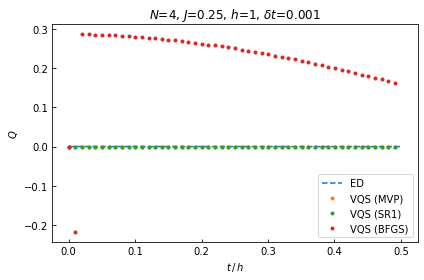

In [53]:
times_ED = np.linspace(0.0,time_max,num_steps)
times_VQS = np.linspace(0.0,time_max,num_steps)
step = 10
plt.plot(times_ED, mag_list_ED,'--',label='ED')
plt.plot(times_VQS[::step],mag_list_VQS[::step],'.',label='VQS (MVP)')
plt.plot(times_VQS[::step],mag_list_VQS_SR1[::step],'.',label='VQS (SR1)')
plt.plot(times_VQS[::step],mag_list_VQS_BFGS[::step],'.',label='VQS (BFGS)')
plt.title(f'$N$={num_qubits}, $J$={j_coupling}, $h$={h_coupling}, $\delta t$={time_max/num_steps:.3f}')
plt.xlabel('$t\, / \, h$')
plt.ylabel('$Q$')
# plt.xlim([0,0.1])
plt.legend()
plt.tight_layout()
# plt.savefig(f'magnetization_N{num_qubits}_J{j_coupling}_h{h_coupling}_dt{time_max/num_steps:.2f}_v1.pdf')
plt.show()